# Step 1: Supervised Learning to Optimize the architecture

In this notebook I have successfully finished the step 1 of the proposed project. For the cases of constant s=1 and s=2 I have been able to optimize a single artificial neural network architecture which can predict the solution to greens function upto an accuracy of atleast 98%. The labelled data I used for supervised learning was the analytical solution given in Equation 4.

# Neural Network Trainer Code

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from torch.optim import SGD, Adam
import torch.nn.functional as F
import random
from tqdm import tqdm
import math
from sklearn.model_selection import train_test_split
from functools import wraps
from time import time

In [2]:
def timing(f):
    @wraps(f)
    def wrap(*args, **kw):
        ts = time()
        result = f(*args, **kw)
        te = time()
        print('func:%r  took: %2.4f sec' % (f.__name__,  te-ts))
        return result
    return wrap

def create_chunks(complete_list, chunk_size=None, num_chunks=None):

    chunks = []
    if num_chunks is None:
        num_chunks = math.ceil(len(complete_list) / chunk_size)
    elif chunk_size is None:
        chunk_size = math.ceil(len(complete_list) / num_chunks)
    for i in range(num_chunks):
        chunks.append(complete_list[i * chunk_size: (i + 1) * chunk_size])
    return chunks

def error_analy(x,y):
    error = np.sum(np.true_divide(abs(x-y),y))*100/(len(y))
    return error

In [3]:
class Trainer_analy():
    def __init__(self, model, error_fn,loss_fn, learning_rate, epoch, batch_size):

        self.model = model
        self.optimizer = Adam(model.parameters(),learning_rate,weight_decay=1e-5)           
        self.epoch = epoch
        self.batch_size = batch_size

    @timing
    def train(self, error_fn,loss_fn,inputs, outputs, val_inputs, val_outputs,early_stop,l2,silent=False):
        ### convert data to tensor of correct shape and type here ###
        inputs = torch.FloatTensor(inputs)
        val_inputs = torch.FloatTensor(val_inputs)
        losses = []
        errors = []
        val_losses = []
        val_errors = []
        weights = self.model.state_dict()
        lowest_val_loss = np.inf
        l2_lambda=1e-5        
        for n_epoch in tqdm(range(self.epoch), leave=False):
            self.model.train()
            batch_indices = list(range(inputs.shape[0]))
            random.shuffle(batch_indices)
            batch_indices = create_chunks(batch_indices, chunk_size=self.batch_size)
            epoch_loss = 0
            epoch_error = 0
            for batch in batch_indices:
                batch_importance = len(batch) / len(outputs)
                batch_input = inputs[batch]
                batch_output = outputs[batch]
                ### make prediction and compute loss with loss function of your choice on this batch ###
                batch_predictions = self.model.forward(batch_input).squeeze(-1)
                #print(batch_predictions.shape)
                loss = loss_fn(batch_predictions,torch.FloatTensor(batch_output))
                if l2:
                    ### Compute the loss with L2 regularization ###
                    l2_norm = sum([p.pow(2.0).sum() for p in self.model.parameters()])
                    loss = loss + l2_lambda * l2_norm
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                ### Compute epoch_loss and epoch_error
                epoch_loss += loss.detach().item()*batch_importance
                error = error_fn(batch_predictions.detach().numpy(),batch_output)
                epoch_error += error*batch_importance
                
            val_loss, val_error = self.evaluate(val_inputs, val_outputs, error_fn,print_error=False)
            if n_epoch % 25 ==0 and not silent: 
                print("Epoch %d/%d - Loss: %.3f - error: %.3f" % (n_epoch + 1, self.epoch, epoch_loss, epoch_error))
                print("              Val_loss: %.3f - Val_error: %.3f" % (val_loss, val_error))
            losses.append(epoch_loss)
            errors.append(epoch_error)
            val_losses.append(val_loss)
            val_errors.append(val_error)
            if early_stop:
                if val_loss < lowest_val_loss:
                    lowest_val_loss = val_loss
                    weights = self.model.state_dict()
        if early_stop:
            self.model.load_state_dict(weights)    

        return self.model,{"losses": losses, "errors": errors, "val_losses": val_losses, "val_errors": val_errors}
        
    def evaluate(self, inputs, outputs,error_fn,print_error=True):
        loss_fn = nn.MSELoss()
        inputs = torch.FloatTensor(inputs) 
        predictions = self.model.forward(inputs).squeeze(-1)
        losses = loss_fn(predictions,torch.FloatTensor(outputs)).item()
        error = np.sum(error_fn(predictions.detach().numpy(),outputs))
        if print_error:
            print("Error: %.3f" % error)
        return losses, error


# Training and validation Code

In [4]:
from sklearn.model_selection import train_test_split,KFold

def train_and_val(model,error_fn,loss_fn,train_X,train_y,val_X,val_y,epochs,batch_size,lr,early_stop,l2,pde,draw_curve=True):
    
    if pde==False:
        ann_trainer = Trainer_analy(model,error_fn,loss_fn,lr, epochs, batch_size)
    else: 
        ann_trainer = Trainer_pde(model,error_fn,loss_fn,lr, epochs, batch_size)
    
    model,ledger  = ann_trainer.train(error_fn,loss_fn,train_X,train_y,val_X,val_y,early_stop,l2)
    val_array = ledger['val_losses']
    train_array = ledger['losses']
    val_error= ledger['val_errors']
    train_error = ledger['errors']
    train_error_all=[]
    if draw_curve:
        plt.figure()
        plt.plot(np.arange(len(val_array))+1,val_array,label='Validation loss')
        plt.plot(np.arange(len(train_array))+1,train_array,label='Training loss')        
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
    
    if draw_curve:
        plt.figure()
        plt.plot(np.arange(len(val_error))+1,val_error,label='Validation Error')
        plt.plot(np.arange(len(train_error))+1,train_error,label='Training Error')        
        plt.xlabel('Epochs')
        plt.ylabel('Error')
        plt.legend()
    
    if early_stop:
            report_idx= np.argmin(ledger["val_losses"])      
    else:
            report_idx=-1
    ### Recover the model weight ###
    weights = model.parameters()

    return model,weights 

# Code for evaluating accuracy/error in test data set

In [5]:

def evaluate_ind(model, inputs, outputs,error_fn,print_error=True):
        loss_fn = nn.MSELoss()
        inputs = torch.FloatTensor(inputs) 
        predictions = model.forward(inputs).squeeze(-1)
        error = error_fn(predictions.detach().numpy(),outputs)
        if print_error:
            print("Testing set Precentage Error: %.3f" % error)
        return error

# Cross-fold validation code

In [6]:
def Kfold(k,model_func,error_fn, loss_fn,Xs,ys,test_X, test_y,epochs,batch_size,lr,early_stop,l2,pde):
    # The total number of examples for training the network
    
    total_num = len(Xs)
    # Built in K-fold function in Sci-Kit Learn
    kf=KFold(n_splits=k,shuffle=True)
    # record error for each model
    train_error_all=[]
    test_error_all=[]
    
    for train_selector,test_selector in kf.split(range(total_num)):
        ### Decide training examples and testing examples for this fold ###
        train_Xs= Xs[train_selector]
        test_Xs= Xs[test_selector]
        train_ys= ys[train_selector]
        test_ys= ys[test_selector]
        model = model_func()
        print(f" parameters:", sum([len(item.flatten()) for item in model.parameters()]))       
        model, weights =train_and_val(model,error_fn,loss_fn,train_Xs,train_ys,test_Xs,test_ys,epochs,batch_size,lr,early_stop,l2,pde,draw_curve = True)
    
        #errors = evaluate_ind(model,test_X, test_y, error_fn,print_error=True)
        
    return model,weights

# Optimized architecture of the neural network.

In [7]:
from torch import nn
import torch
        

class ann(nn.Module):
    def __init__(self):
        super(ann, self).__init__()
        a = 100
        inp = 3
        self.Linear = nn.ModuleList([nn.Linear(inp,a),nn.Linear(a,a)
                                     ,nn.Linear(a,a),nn.Linear(a,a)
                                     ,nn.Linear(a,100),nn.Linear(100,1)])
        self.activation = nn.ModuleList([nn.Tanh()])
    def forward(self, x):
        for i in range(len(self.Linear)-1):
            x = self.activation[0](self.Linear[i](x))
        x = self.Linear[-1](x)  
        return x

print(ann())  

ann(
  (Linear): ModuleList(
    (0): Linear(in_features=3, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=100, bias=True)
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): Linear(in_features=100, out_features=100, bias=True)
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): Linear(in_features=100, out_features=1, bias=True)
  )
  (activation): ModuleList(
    (0): Tanh()
  )
)


# Labelled data generation function from analytical solution

In [8]:
def data_generator(N,s):
    train_X = np.zeros((N,3))
    train_y = np.zeros((N))
    

    for i in range(N):
        train_X[i,0] = s#0*np.random.rand() + 0.01 #s
        train_X[i,1] = 2*np.random.rand() - 1.0 #x
        train_X[i,2] = 2*np.random.rand() - 1.0 #x'
        train_y[i] = np.exp(-train_X[i,0]*abs(train_X[i,1]-train_X[i,2]))/(2*train_X[i,0])
        
    return train_X,train_y  

# Neural Network training and testing

 parameters: 40901


  2%|▏         | 1/50 [00:00<00:25,  1.92it/s]

Epoch 1/50 - Loss: 0.004 - error: 99.834
              Val_loss: 0.001 - Val_error: 78.878


 52%|█████▏    | 26/50 [00:13<00:12,  1.99it/s]

Epoch 26/50 - Loss: 0.000 - error: 6.222
              Val_loss: 0.000 - Val_error: 5.189


func:'train'  took: 24.9730 sec
 parameters: 40901


  2%|▏         | 1/50 [00:00<00:25,  1.94it/s]

Epoch 1/50 - Loss: 0.004 - error: 100.720
              Val_loss: 0.002 - Val_error: 78.134


 52%|█████▏    | 26/50 [00:13<00:12,  1.99it/s]

Epoch 26/50 - Loss: 0.000 - error: 7.706
              Val_loss: 0.000 - Val_error: 9.775


func:'train'  took: 26.5428 sec
 parameters: 40901


  2%|▏         | 1/50 [00:00<00:24,  1.97it/s]

Epoch 1/50 - Loss: 0.004 - error: 101.821
              Val_loss: 0.001 - Val_error: 71.541


 52%|█████▏    | 26/50 [00:20<00:18,  1.32it/s]

Epoch 26/50 - Loss: 0.000 - error: 7.720
              Val_loss: 0.000 - Val_error: 9.246


func:'train'  took: 34.1506 sec
 parameters: 40901


  2%|▏         | 1/50 [00:00<00:25,  1.95it/s]

Epoch 1/50 - Loss: 0.005 - error: 109.574
              Val_loss: 0.001 - Val_error: 72.238


 52%|█████▏    | 26/50 [00:13<00:12,  1.96it/s]

Epoch 26/50 - Loss: 0.000 - error: 6.920
              Val_loss: 0.000 - Val_error: 9.168


func:'train'  took: 25.1049 sec
 parameters: 40901


  2%|▏         | 1/50 [00:00<00:25,  1.94it/s]

Epoch 1/50 - Loss: 0.004 - error: 97.840
              Val_loss: 0.001 - Val_error: 70.276


 52%|█████▏    | 26/50 [00:13<00:12,  2.00it/s]

Epoch 26/50 - Loss: 0.000 - error: 8.250
              Val_loss: 0.000 - Val_error: 5.310


func:'train'  took: 25.3280 sec


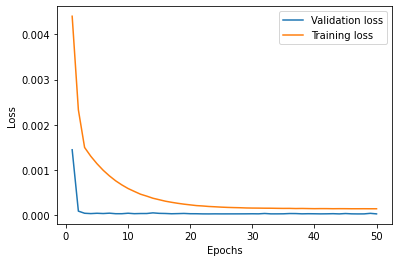

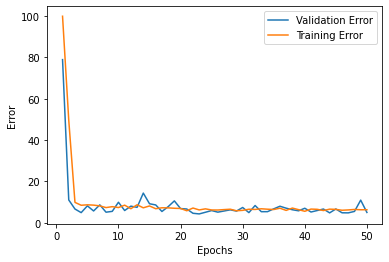

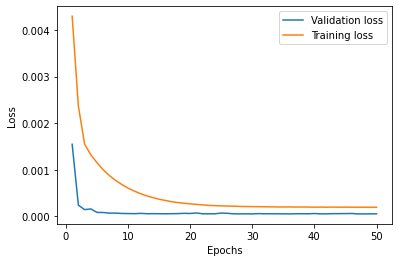

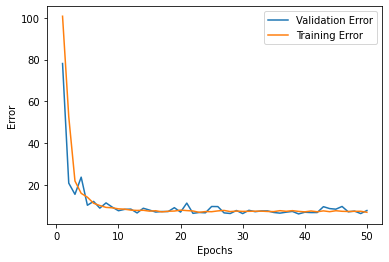

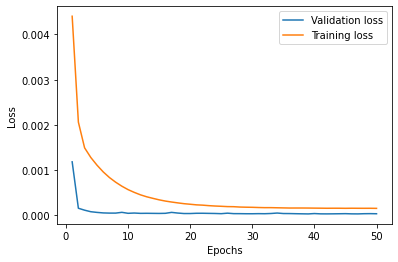

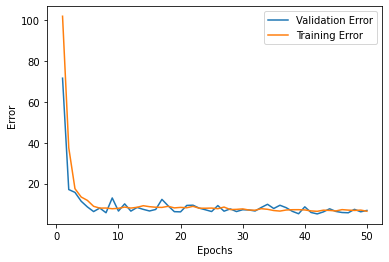

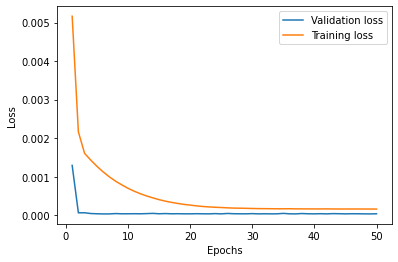

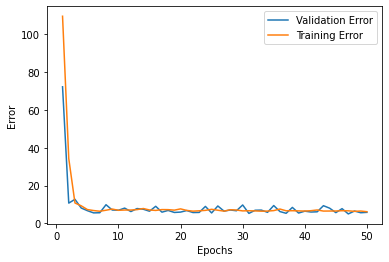

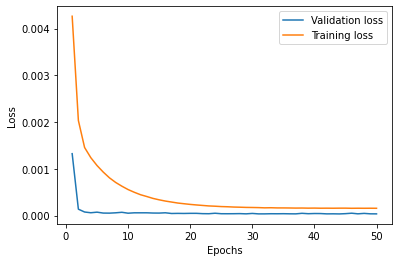

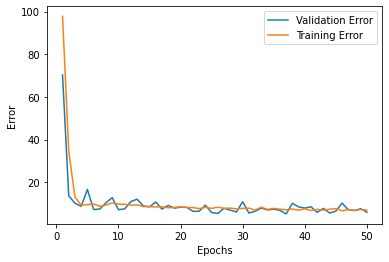

In [9]:
train_X,train_y = data_generator(100000,2)
test_X,test_y = data_generator(1000,2)
model, weights = Kfold(5,ann,error_analy,nn.MSELoss(),train_X,train_y,test_X,test_y,50,500,lr=1e-3,early_stop=True,l2=True,pde=False)

In [10]:
print('Percentage error in test set for s=2')

errors = evaluate_ind(model,test_X, test_y, error_analy,print_error=True)

Percentage error in test set for s=2
Testing set Precentage Error: 5.725


 parameters: 40901


  2%|▏         | 1/50 [00:00<00:25,  1.91it/s]

Epoch 1/50 - Loss: 0.008 - error: 22.362
              Val_loss: 0.000 - Val_error: 3.716


 52%|█████▏    | 26/50 [00:13<00:12,  1.94it/s]

Epoch 26/50 - Loss: 0.000 - error: 1.869
              Val_loss: 0.000 - Val_error: 2.342


func:'train'  took: 26.3063 sec
 parameters: 40901


  2%|▏         | 1/50 [00:00<00:25,  1.95it/s]

Epoch 1/50 - Loss: 0.008 - error: 24.013
              Val_loss: 0.000 - Val_error: 4.106


 52%|█████▏    | 26/50 [00:13<00:12,  1.97it/s]

Epoch 26/50 - Loss: 0.000 - error: 1.482
              Val_loss: 0.000 - Val_error: 1.403


func:'train'  took: 25.4020 sec
 parameters: 40901


  2%|▏         | 1/50 [00:00<00:25,  1.93it/s]

Epoch 1/50 - Loss: 0.006 - error: 20.571
              Val_loss: 0.000 - Val_error: 4.509


 52%|█████▏    | 26/50 [00:13<00:12,  2.00it/s]

Epoch 26/50 - Loss: 0.000 - error: 1.625
              Val_loss: 0.000 - Val_error: 1.399


func:'train'  took: 28.6110 sec
 parameters: 40901


  2%|▏         | 1/50 [00:00<00:24,  1.97it/s]

Epoch 1/50 - Loss: 0.007 - error: 21.195
              Val_loss: 0.000 - Val_error: 3.761


 52%|█████▏    | 26/50 [00:12<00:12,  1.98it/s]

Epoch 26/50 - Loss: 0.000 - error: 1.536
              Val_loss: 0.000 - Val_error: 1.466


func:'train'  took: 25.7126 sec
 parameters: 40901


  2%|▏         | 1/50 [00:00<00:24,  1.96it/s]

Epoch 1/50 - Loss: 0.007 - error: 20.279
              Val_loss: 0.000 - Val_error: 3.555


 52%|█████▏    | 26/50 [00:14<00:14,  1.60it/s]

Epoch 26/50 - Loss: 0.000 - error: 1.624
              Val_loss: 0.000 - Val_error: 2.568


func:'train'  took: 29.0541 sec


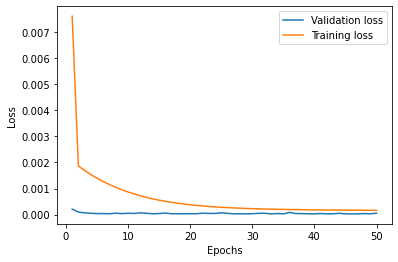

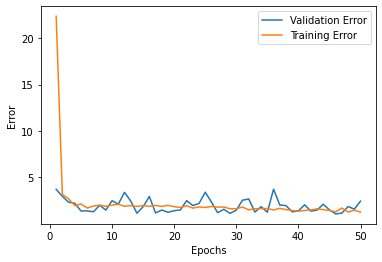

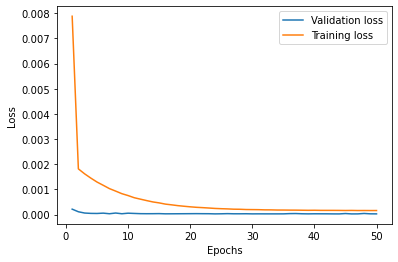

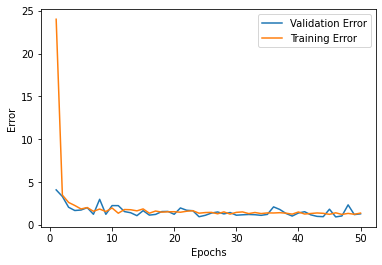

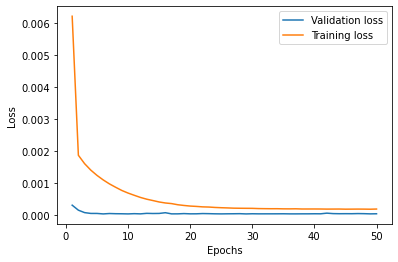

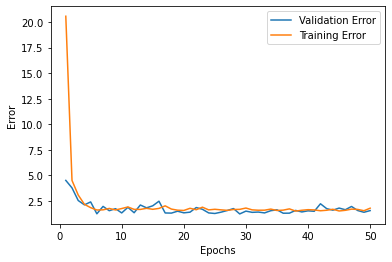

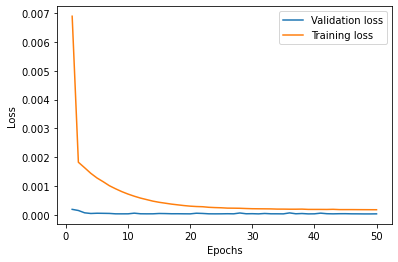

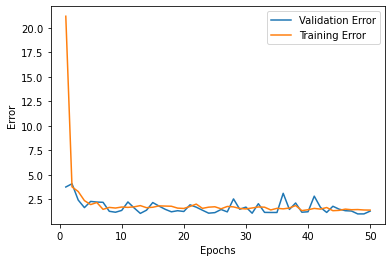

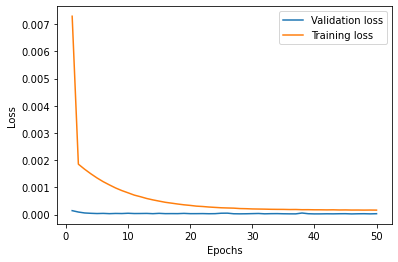

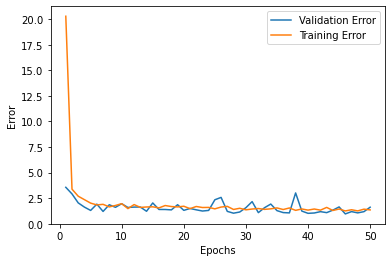

In [12]:
train_X,train_y = data_generator(100000,1)
test_X,test_y = data_generator(1000,1)
model, weights = Kfold(5,ann,error_analy,nn.MSELoss(),train_X,train_y,test_X,test_y,50,500,lr=1e-3,early_stop=True,l2=True,pde=False)

In [13]:
print('Percentage error in test set for s=1')

errors = evaluate_ind(model,test_X, test_y, error_analy,print_error=True)

Percentage error in test set for s=1
Testing set Precentage Error: 1.605
